In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from transformers import Trainer, TrainingArguments, AutoModelForImageClassification, CLIPVisionModel, CLIPModel, CLIPProcessor, CLIPTokenizer
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from tqdm import tqdm
from datetime import datetime
import clip

# Data Visualization/Pre-Processing

In [3]:
data_path = 'data/archive/compressed_dataset/' # change this according to where you put your data
batch_size = 4
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# define custom dataset to support CLIP
class GeoDataset(Dataset):
    def __init__(self, image_paths, countries):
        self.image_path = image_paths
        self.countries = clip.tokenize(countries)


    def __len__(self):
        return len(self.countries)
    
    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_path[idx]))
        # image = Image.open(self.image_path[idx])
        # print("Load image: " + self.image_path[idx])
        text = self.countries[idx]
        label = self.image_path[idx].split('/')[-1].split('\\')[0]
        return image, text, label

In [5]:
# get a list of all images and their corresponding country labels
image_paths = []
country_labels = []

for country in os.listdir(data_path):
    country_path = os.path.join(data_path, country)
    for img in os.listdir(country_path):
        img_path = os.path.join(country_path, img)
        image_paths.append(img_path)
        country_labels.append(country)

In [31]:
# # transform images to tensors for training compatibility
# transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     # transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# # create a datset object and loads images into it then put it into a dataloader to be compatible with training
# image_dataset = datasets.ImageFolder(os.path.join(data_path), transform)
image_dataset = GeoDataset(image_paths=image_paths, countries=country_labels)
class_names = os.listdir(data_path)
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=4)

# # split train and validation sets (80:20)
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(image_dataset, [train_size, val_size])
train_set_limited = torch.utils.data.Subset(train_set, range(0, 5000))
val_set_limited = torch.utils.data.Subset(val_set, range(0, 1000))

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_set_limited, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set_limited, batch_size=batch_size, shuffle=True)

tensor([[49406,  3400, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406, 27584, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

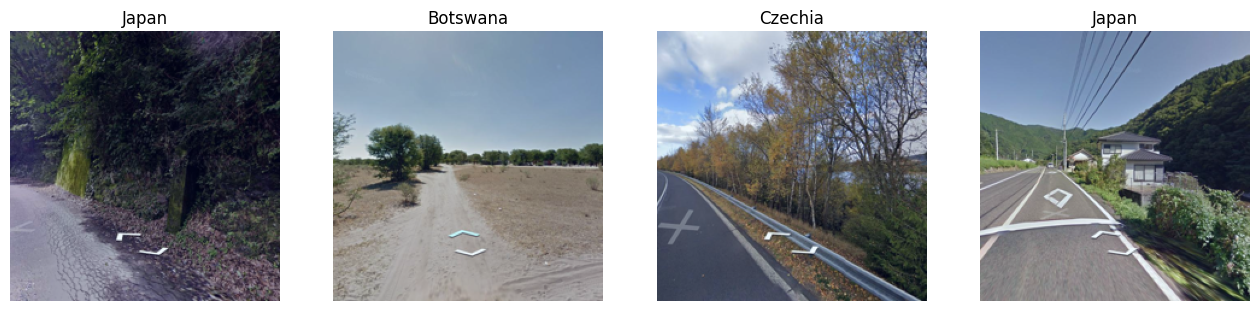

In [37]:
# Retrieve images and labels
images, texts, labels = next(iter(train_loader))

# Normalize images
images -= images.min()
images /= images.max()

# Display images
fig = plt.figure(figsize=(16,10))
for i in range(4):
  fig.add_subplot(1, 4, i+1)
  plt.imshow(images[i].permute(1, 2, 0))
  plt.title(labels[i])
  plt.axis('off')

### Create Heatmap

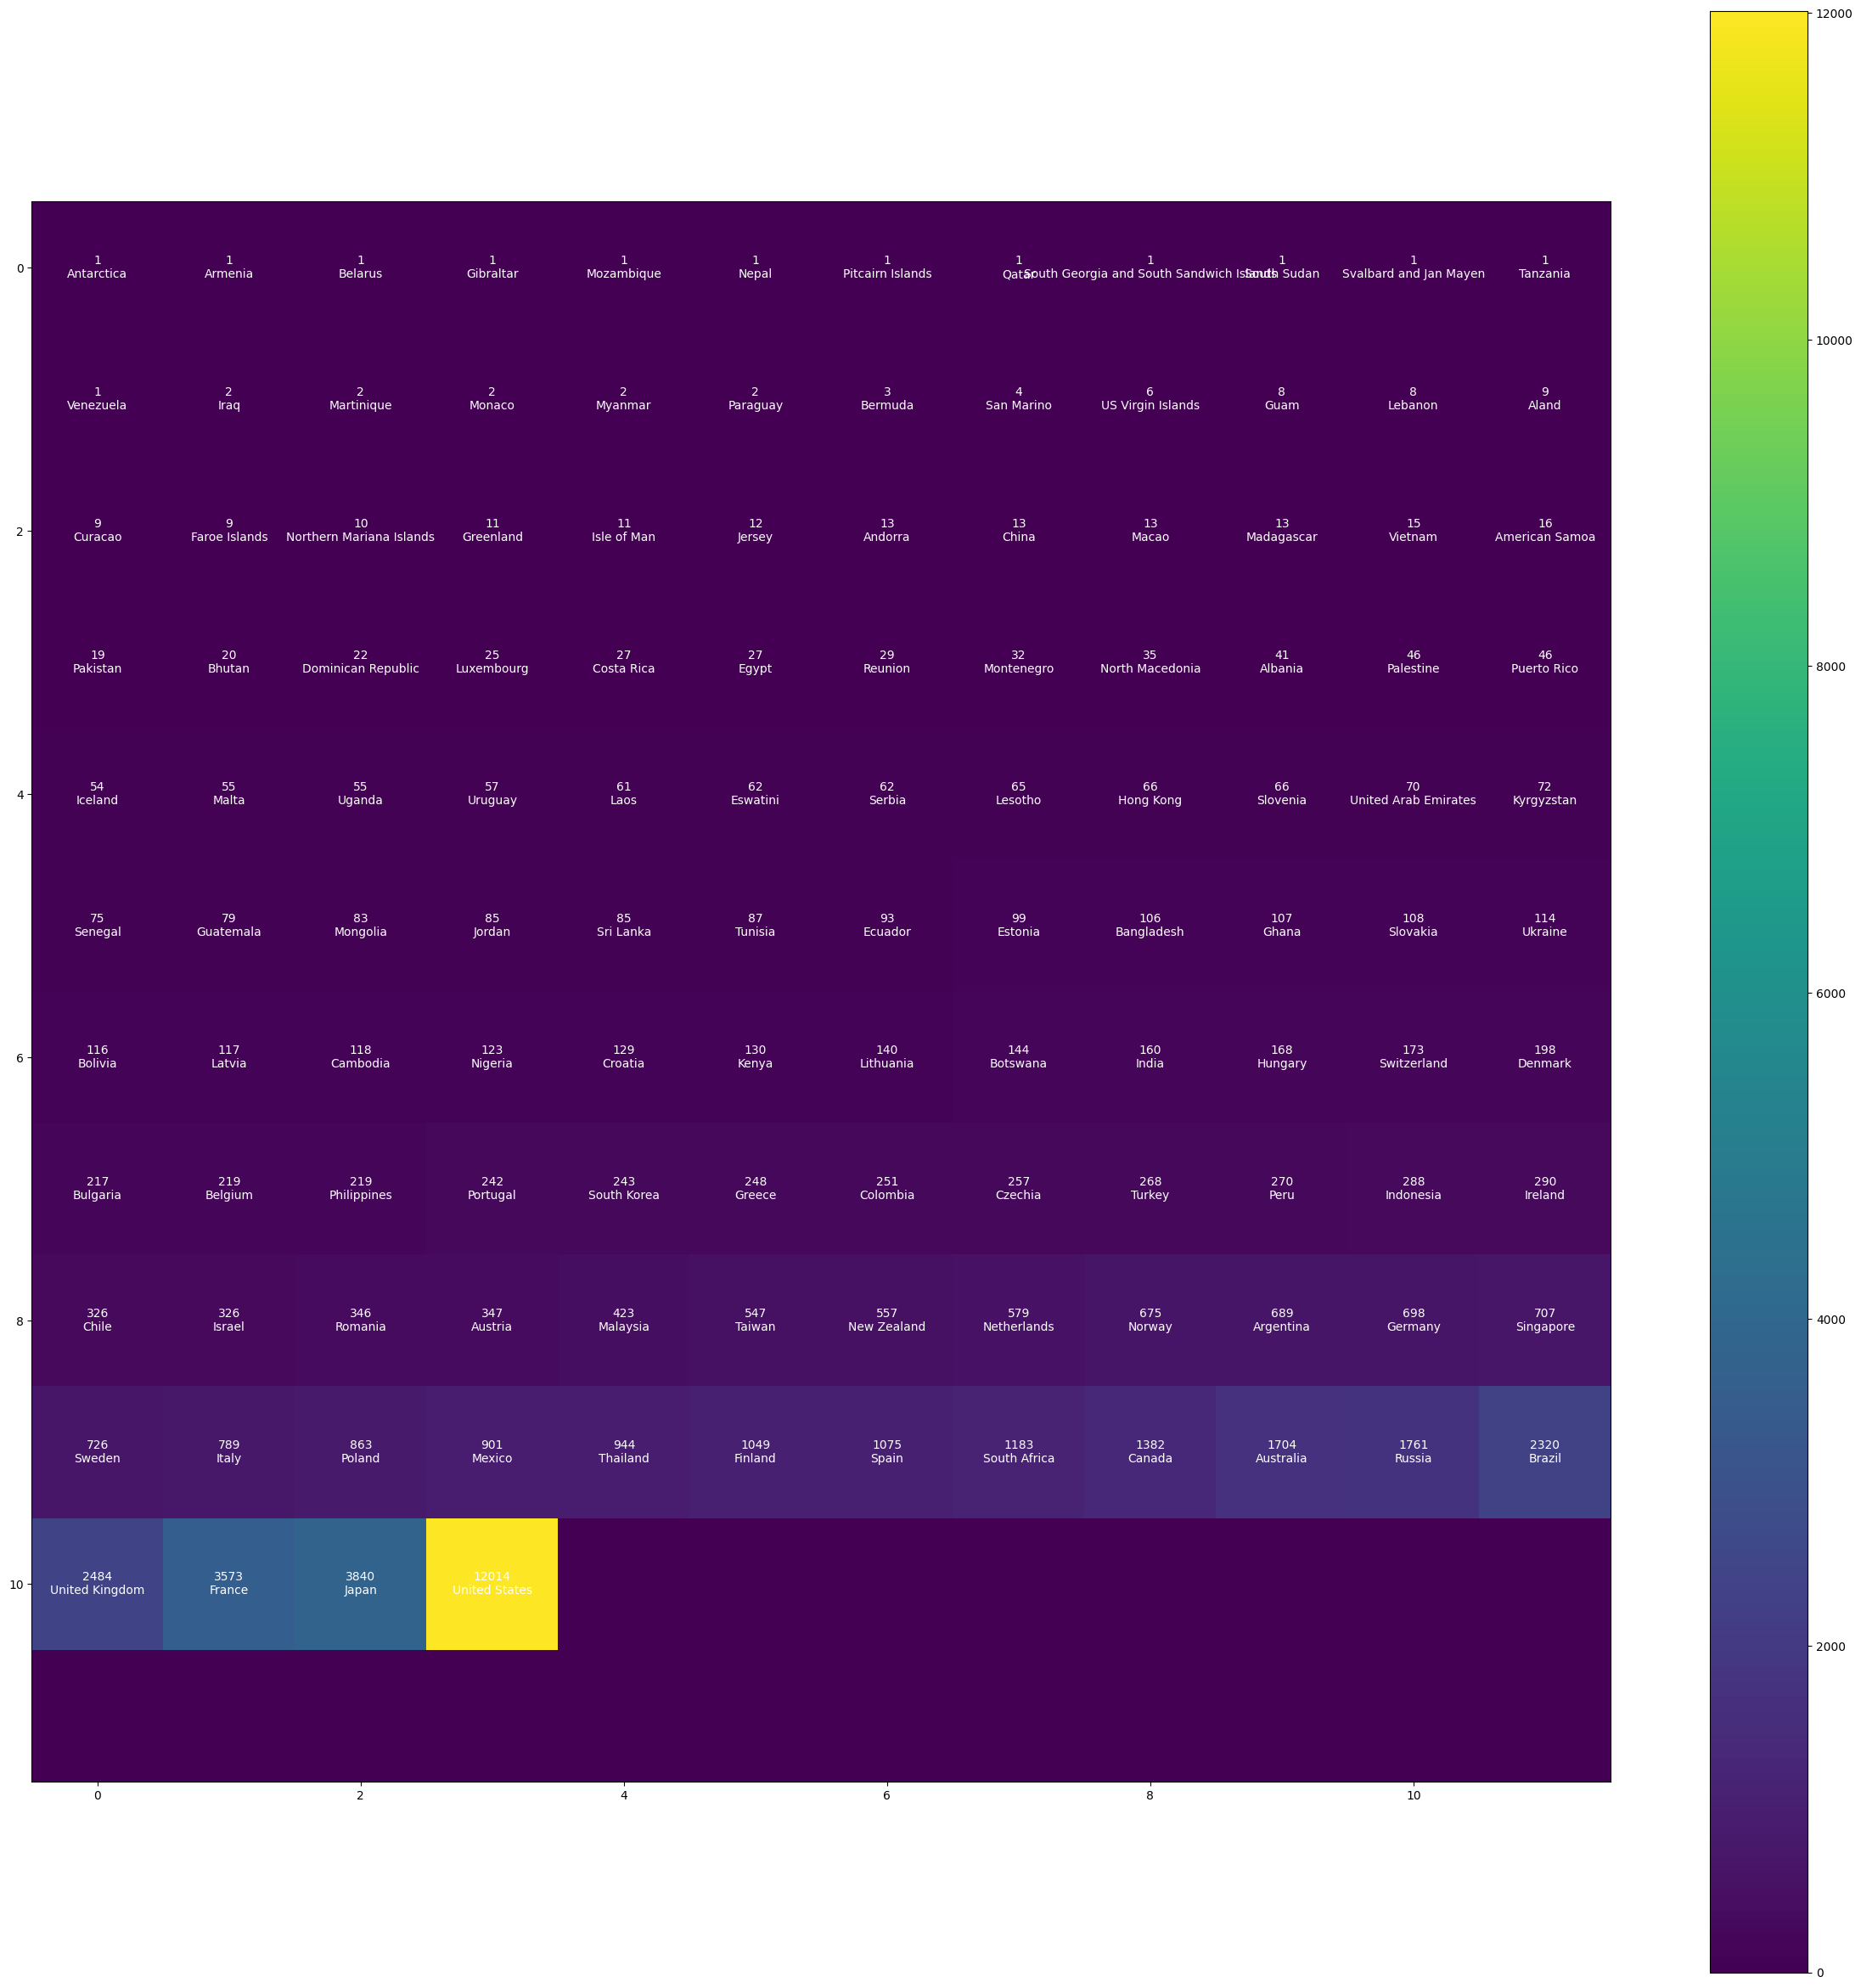

In [6]:
from math import sqrt, ceil
import numpy as np
import matplotlib.pyplot as plt
import pathlib

data_path = pathlib.Path(data_path)
def count_samples(path):
    return path.name, len(list(path.glob('*')))

zipped_data_distribution = list(map(count_samples, data_path.glob('*/')))

# Sort the zipped_data_distribution based on the number of pictures
zipped_data_distribution.sort(key=lambda x: x[1])

# Extract labels and numbers
labels = [item[0] for item in zipped_data_distribution]
numbers = [item[1] for item in zipped_data_distribution]
grid_size = ceil(sqrt(len(labels)))

grid = np.zeros((grid_size, grid_size), dtype=int)
for i, num in enumerate(numbers):
    row = i // grid_size
    col = i % grid_size
    grid[row, col] = num
 
# Create the heatmap
plt.figure(figsize=(30, 30))  # Set the size of the figure (width, height)
plt.imshow(grid, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add color bar

# Add annotations
for i in range(grid_size):
    for j in range(grid_size):
        if(i*grid_size+j<len(labels)):
            plt.text(j, i, f'{grid[i, j]}\n{labels[i*grid_size+j]}', ha='center', va='center', color='white')

plt.show()





# Training

In [66]:
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

In [68]:
print(f"Using {device}")

# get pretrained models
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

# set up cuda support
model.to(device)
model.train()

# set up optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.98), eps=1e-6, weight_decay=0.2)
img_loss = nn.CrossEntropyLoss()
txt_loss = nn.CrossEntropyLoss()

epochs = 1

# train the model
for epoch in range(epochs):
    pbar = tqdm(train_loader, total=len(train_loader))
    for batch in pbar:
        optimizer.zero_grad()
        
        images, texts, labels = batch

        images = images.to(device)
        texts = texts.to(device)
        
        logits_per_image, logits_per_text = model(images, texts)
        
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        
        total_loss = (img_loss(logits_per_image,ground_truth) + txt_loss(logits_per_text,ground_truth))/2
        total_loss.backward()

        if device == "cpu":
            optimizer.step()
        else : 
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{epochs}, Loss: {total_loss.item():.4f}")
    # for inputs, target in train_loader:
    #     inputs, targets = inputs.to(device), targets.to(device)
    #     optimizer.zero_grad()    

Using cuda


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 0/1, Loss: 1.3867: 100%|██████████| 1250/1250 [11:51<00:00,  1.76it/s]


In [69]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'{timestamp}_model.pt'
torch.save(model.state_dict(), "models/"+filename)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("models/20240428-154030_model.pt"))

model = model.to(device)
model.eval()
images, texts, labels = next(iter(val_loader))
image_input = images[0].unsqueeze(0).to(device)
text_inputs = texts[0].to(device)
print(texts[0])

with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(3)


images -= images.min()
images /= images.max()
fig = plt.figure(figsize=(16,10))
fig.add_subplot(1, 5, 1)
plt.imshow(images[0].permute(1, 2, 0))
plt.title(labels[0])

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{class_names[index.item()]:>16s}: {100*value.item():.2f}%")






TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor